# Training Neural Networks with Transfer Learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transfer learning / fine-tuning

Transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model. More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. 

This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on). 


## Procedure

In this project, it will be used the images from the dataset https://www.tensorflow.org/datasets/catalog/cats_vs_dogs (it can also be accessed by https://www.microsoft.com/en-us/download/details.aspx?id=54765). 
For this project we will use the project Transfer Learning with the MNIST Dataset as a reference. 



### Libraries

In [2]:
%matplotlib inline

import os
import zipfile

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image

### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset [cats_vs_dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765). 

To obtain this dataset, you can either run the download script `download.sh` in the `data` folder, or the following commands:

    !wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
        -O /tmp/cats_and_dogs_filtered.zip

Bellow is our data loaded:

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-10-30 22:20:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 142.251.45.16, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   165MB/s    in 0.4s    

2022-10-30 22:20:48 (165 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
root = '/tmp/cats_and_dogs_filtered'
exclude = ["PetImages/Cat/666.jpg", "PetImages/Dog/11702.jpg"]
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['/tmp/cats_and_dogs_filtered/train', '/tmp/cats_and_dogs_filtered/train/dogs', '/tmp/cats_and_dogs_filtered/train/cats', '/tmp/cats_and_dogs_filtered/validation', '/tmp/cats_and_dogs_filtered/validation/dogs', '/tmp/cats_and_dogs_filtered/validation/cats']


This function is useful for pre-processing the data into an image and input vector:

In [6]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Loading all the images from root folder:

In [7]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomizing the data order:

In [8]:
random.shuffle(data)

The next step is to create the training, validation, test split (70%, 15%, 15% 
respectively).

In [9]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separating data for labels:

In [10]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 2, 4, 0, 1, 0, 2, 0, 0, 1, 5, 0, 4, 3, 3, 5, 1, 1, 0, 2, 2, 0, 0, 0, 4, 2, 0, 0, 0, 3, 4, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 5, 3, 3, 0, 1, 0, 2, 4, 1, 0, 0, 4, 4, 0, 3, 0, 0, 3, 3, 4, 5, 1, 0, 4, 4, 2, 2, 1, 1, 2, 3, 0, 5, 0, 4, 3, 5, 0, 1, 0, 0, 2, 4, 3, 2, 5, 0, 0, 5, 0, 0, 1, 1, 2, 4, 0, 2, 0, 1, 0, 1, 2, 0, 4, 0, 3, 0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 2, 3, 4, 0, 5, 1, 4, 4, 1, 2, 5, 0, 0, 0, 3, 2, 4, 2, 0, 2, 0, 3, 3, 1, 1, 0, 3, 4, 0, 0, 0, 1, 0, 0, 4, 5, 3, 0, 1, 0, 0, 1, 5, 4, 3, 1, 0, 0, 5, 0, 3, 3, 0, 3, 5, 1, 4, 4, 0, 3, 1, 0, 2, 1, 1, 0, 1, 2, 5, 3, 0, 2, 2, 1, 1, 2, 0, 0, 4, 5, 0, 1, 2, 5, 4, 3, 1, 1, 3, 0, 5, 4, 1, 2, 0, 3, 0, 0, 2, 5, 3, 0, 0, 0, 0, 3, 2, 0, 5, 0, 1, 2, 4, 2, 2, 5, 3, 2, 1, 2, 0, 1, 2, 0, 3, 5, 3, 0, 2, 3, 3, 0, 0, 4, 0, 3, 3, 1, 3, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1, 0, 4, 0, 1, 1, 2, 3, 0, 2, 1, 0, 2, 2, 0, 0, 3, 1, 0, 0, 3, 2, 5, 1, 0, 2, 3, 1, 2, 0, 1, 0, 4, 0, 2, 0, 0, 2, 3, 1, 0, 3, 2, 3, 4, 0, 1, 3, 2, 2, 1, 0, 0, 2, 0, 4, 0, 1, 1, 0, 0, 5, 3, 

Pre-processing the data as before by making sure it's float32 and normalized between 0 and 1:

In [11]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(900, 6)


Summary:

In [12]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6000 images from 6 categories
train / validation / test split: 4200, 900, 900
training data shape:  (4200, 224, 224, 3)
training labels shape:  (4200, 6)


Notice that we divided all the data into three subsets -- a training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

A few sample images from our dataset:

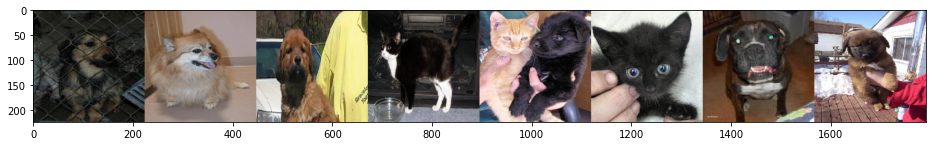

In [13]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [14]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

We've created a medium-sized network with ~1.2 million weights and biases (the parameters).

We can now go ahead and train our model for 10 epochs with a batch size of 50. We'll also record its history so we can plot the loss over time later. 

In [15]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=50,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
84/84 [==============================] - 170s 2s/step - loss: 1.6983 - accuracy: 0.3262 - val_loss: 1.6852 - val_accuracy: 0.3389
Epoch 2/10
84/84 [==============================] - 170s 2s/step - loss: 1.6870 - accuracy: 0.3305 - val_loss: 1.6776 - val_accuracy: 0.3389
Epoch 3/10
84/84 [==============================] - 185s 2s/step - loss: 1.6772 - accuracy: 0.3302 - val_loss: 1.6613 - val_accuracy: 0.3389
Epoch 4/10
84/84 [==============================] - 171s 2s/step - loss: 1.6597 - accuracy: 0.3300 - val_loss: 1.6607 - val_accuracy: 0.3411
Epoch 5/10
84/84 [==============================] - 170s 2s/step - loss: 1.6605 - accuracy: 0.3329 - val_loss: 1.6803 - val_accuracy: 0.3389
Epoch 6/10
84/84 [==============================] - 168s 2s/step - loss: 1.6538 - accuracy: 0.3326 - val_loss: 1.6594 - val_accuracy: 0.3378
Epoch 7/10
84/84 [==============================] - 168s 2s/step - loss: 1.6418 - accuracy: 0.3283 - val_loss: 1.6448 - val_accuracy: 0.3367
Epoch 8/10
84

Ploting the validation loss and validation accuracy over time:

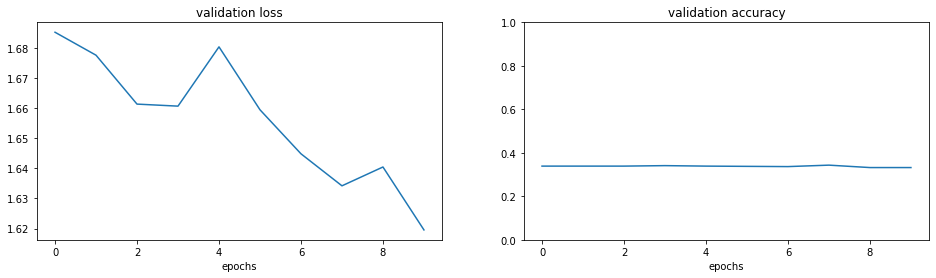

In [16]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [17]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.6021732091903687
Test accuracy: 0.31111112236976624


Finally, we see that we have achieved an accuracy of around 31%. 

### Transfer learning by starting with existing network

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the `summary()` method.

In [18]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [19]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset. 

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of CalTech-101, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [20]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [21]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=50, 
                         epochs=5, 
                         validation_data=(x_val, y_val))


Epoch 1/5
84/84 [==============================] - 2213s 26s/step - loss: 1.7461 - accuracy: 0.2781 - val_loss: 1.7037 - val_accuracy: 0.3211
Epoch 2/5
84/84 [==============================] - 1938s 23s/step - loss: 1.6252 - accuracy: 0.3107 - val_loss: 1.7803 - val_accuracy: 0.3300
Epoch 3/5
84/84 [==============================] - 1981s 24s/step - loss: 1.6245 - accuracy: 0.3050 - val_loss: 1.7177 - val_accuracy: 0.2422
Epoch 4/5
84/84 [==============================] - 1992s 24s/step - loss: 1.5753 - accuracy: 0.3145 - val_loss: 1.6418 - val_accuracy: 0.3144
Epoch 5/5
84/84 [==============================] - 2019s 24s/step - loss: 1.5266 - accuracy: 0.3255 - val_loss: 1.5677 - val_accuracy: 0.2933


Ploting the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model.

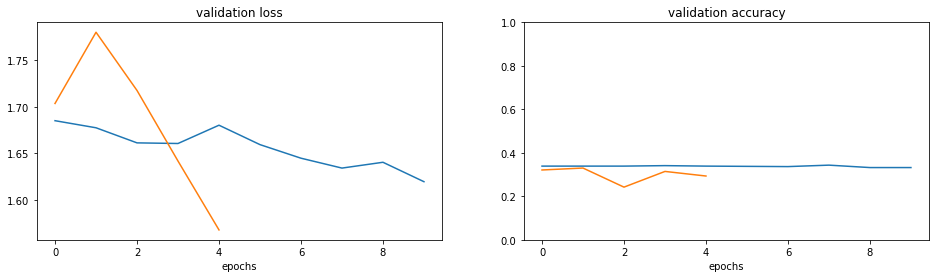

In [22]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Again, we do a final validation on the test set:

In [23]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.5475417375564575
Test accuracy: 0.30000001192092896
